In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch.optim import lr_scheduler

In [2]:
from scipy import io
mat_file = io.loadmat('data/PRW-v16.04.20/PRW-v16.04.20/ID_train.mat')

In [4]:
import os
from glob import glob

# proposed  경로 리스트
def make_file_list2():
    train_img_list1 = []
    train_img_list2 = []
    for image_path1 in glob('data/PRW-v16.04.20/PRW-v16.04.20/query_box/*.jpg') :
        user_id_1 = image_path1.split('query_box\\')[1].split('_')[0]
        
        for image_path2 in glob('data/PRW-v16.04.20/PRW-v16.04.20/query_box/*.jpg') :
            user_id_2 = image_path2.split('query_box\\')[1].split('_')[0]

            if user_id_1 == user_id_2 :
                train_img_list1.append(image_path1)
                train_img_list2.append(image_path2)
                
        
    return train_img_list1, train_img_list2

In [44]:
import os
from glob import glob

# p경로 리스트
def make_file_list1():
    train_img_list = []
    for image_path in glob('data/PRW-v16.04.20/PRW-v16.04.20/query_box/*.jpg') :
        
        train_img_list.append(image_path)
    
    return train_img_list

In [38]:
#이미지 불러오고 라벨링하는 클래스
from torch.utils.data import Dataset
from PIL import Image


class Custom_Img_Dataset(Dataset):

    def __init__(self, file_list, transform = None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        
        img_path = self.file_list[index] # 데이터셋에서 파일 하나를 특정
        img = Image.open(img_path)
        
        user_id = img_path.split('query_box\\')[1].split('_')[0]
        
        if self.transform == None :
            tensor_image = img
        else :
            tensor_image = self.transform(img)
            
        return tensor_image, user_id
    

In [39]:
class Custom_Img_Dataset2(Dataset):

    def __init__(self, file_list, transform = None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        
        img_path = self.file_list[index] # 데이터셋에서 파일 하나를 특정
        img = Image.open(img_path)
        
        user_id = img_path.split('query_box\\')[1].split('_')[0]
        
        if self.transform == None :
            tensor_image = img
        else :
            tensor_image = self.transform(img)
            
        return tensor_image, user_id
    

In [45]:
test_dataset = make_file_list1()

In [46]:
test_dataset = Custom_Img_Dataset(test_dataset)

In [16]:
dataset1, dataset2 = make_file_list2()



In [17]:
custom_dataset1 = Custom_Img_Dataset(dataset1)

In [18]:
custom_dataset2 = Custom_Img_Dataset2(dataset2)

In [19]:
import numpy as np

torch.manual_seed(0)

#테스트, 트레이닝 데이터 나누기
train_size = int(1 * len(custom_dataset1))
test_size = len(custom_dataset1) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(custom_dataset1, [train_size, test_size])
train_dataset1, test_dataset1 = torch.utils.data.random_split(custom_dataset2, [train_size, test_size])

In [47]:
trainTransform_training  = transforms.Compose([ transforms.Resize((32, 32)), 
                                               #transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()
                                    #, transforms.Normalize((0.5,), (0.5,))
                                              ])


In [48]:
test_dataset.transform = trainTransform_training

In [50]:
testloader = torch.utils.data.DataLoader(test_dataset , batch_size=100, shuffle=False, 
                               num_workers=0, drop_last=False)

In [ ]:
custom_dataset1.transform = trainTransform_training
custom_dataset2.transform = trainTransform_training

In [21]:
trainloader = torch.utils.data.DataLoader(custom_dataset1 , batch_size=100, shuffle=False, 
                               num_workers=0, drop_last=False)
trainloader1 = torch.utils.data.DataLoader(custom_dataset2 , batch_size=100, shuffle=False, 
                               num_workers=0, drop_last=False)

In [22]:
len(trainloader)

98

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            Reshape((-1,4*8*8)),
            nn.Linear(4*8*8, 2*8*8),

        )
        self.decoder = nn.Sequential(
            nn.Linear(2*8*8, 4*8*8),
            nn.LeakyReLU(),
            Reshape((-1,4,8,8)),
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid()
            
        )
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out
    
    def num_flat_features(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

In [26]:
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
model = AutoEncoder().to(device)
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: 1 	Training Loss: 66.805711


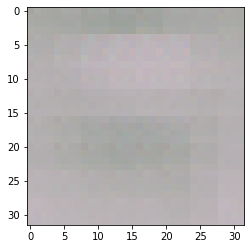

Epoch: 2 	Training Loss: 66.447348


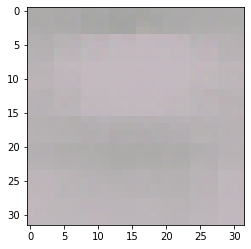

Epoch: 3 	Training Loss: 66.001623


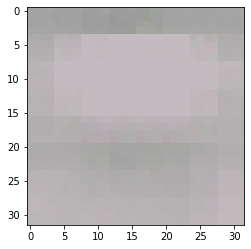

Epoch: 4 	Training Loss: 65.817280


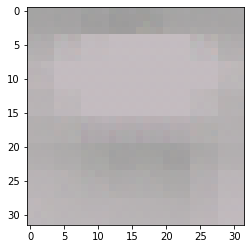

Epoch: 5 	Training Loss: 65.760018


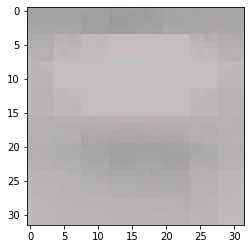

Epoch: 6 	Training Loss: 65.715697


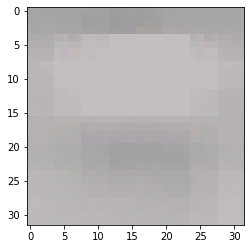

Epoch: 7 	Training Loss: 65.676796


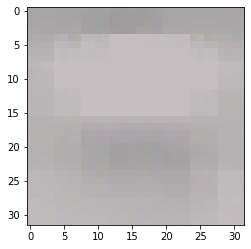

Epoch: 8 	Training Loss: 65.646354


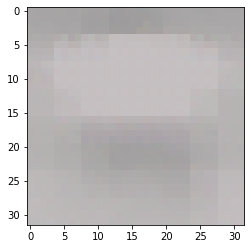

Epoch: 9 	Training Loss: 65.617915


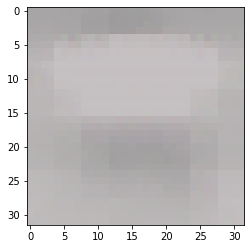

Epoch: 10 	Training Loss: 65.592521


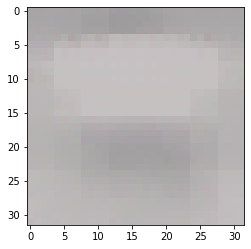

Epoch: 11 	Training Loss: 65.568050


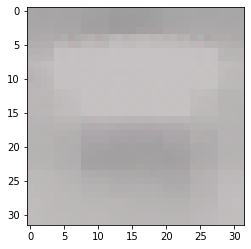

Epoch: 12 	Training Loss: 65.546130


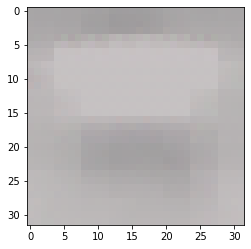

Epoch: 13 	Training Loss: 65.530151


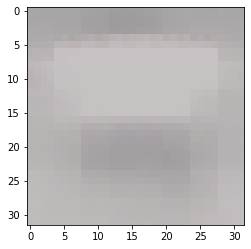

Epoch: 14 	Training Loss: 65.513492


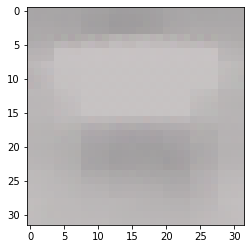

Epoch: 15 	Training Loss: 65.498608


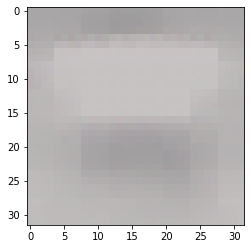

Epoch: 16 	Training Loss: 65.484950


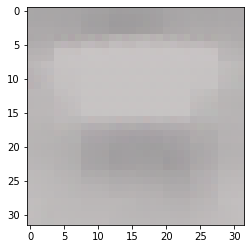

Epoch: 17 	Training Loss: 65.471975


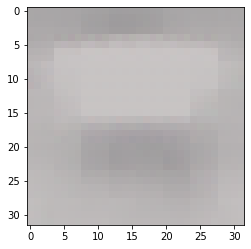

Epoch: 18 	Training Loss: 65.459563


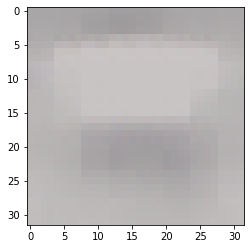

Epoch: 19 	Training Loss: 65.447866


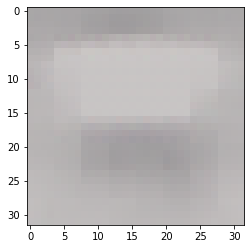

Epoch: 20 	Training Loss: 65.436327


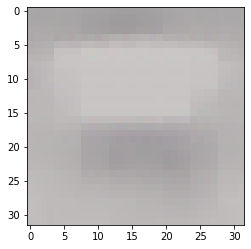

Epoch: 21 	Training Loss: 65.425743


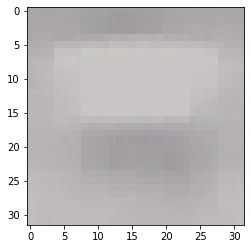

Epoch: 22 	Training Loss: 65.415221


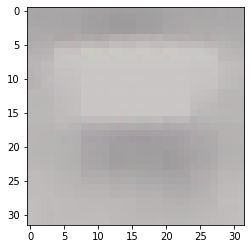

Epoch: 23 	Training Loss: 65.405335


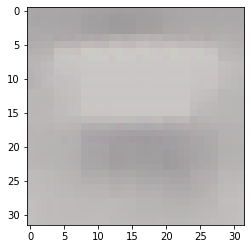

Epoch: 24 	Training Loss: 65.396135


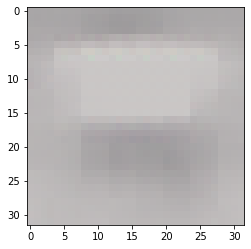

Epoch: 25 	Training Loss: 65.385397


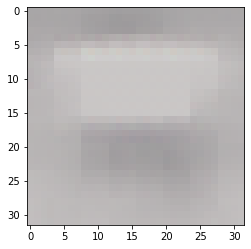

Epoch: 26 	Training Loss: 65.375215


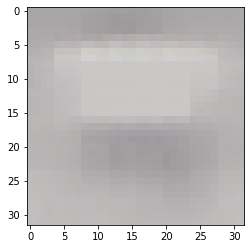

Epoch: 27 	Training Loss: 65.365426


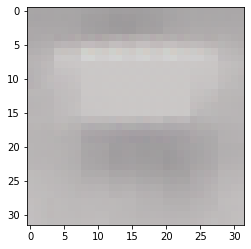

Epoch: 28 	Training Loss: 65.357218


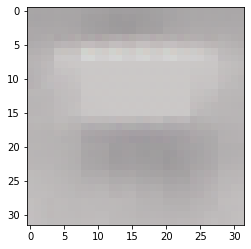

Epoch: 29 	Training Loss: 65.348933


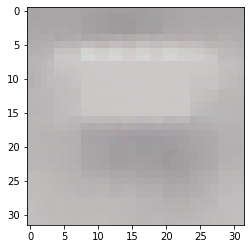

Epoch: 30 	Training Loss: 65.340654


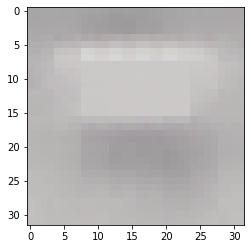

Epoch: 31 	Training Loss: 65.333744


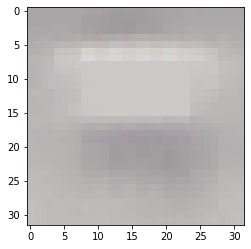

Epoch: 32 	Training Loss: 65.326861


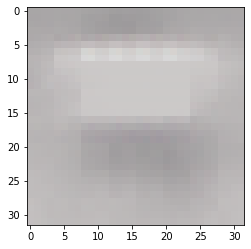

Epoch: 33 	Training Loss: 65.319866


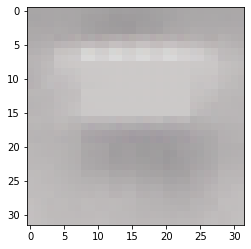

Epoch: 34 	Training Loss: 65.313580


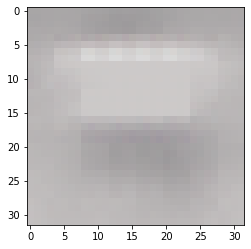

Epoch: 35 	Training Loss: 65.307092


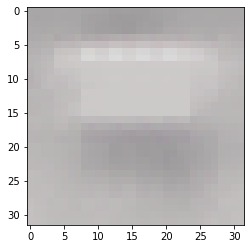

Epoch: 36 	Training Loss: 65.300945


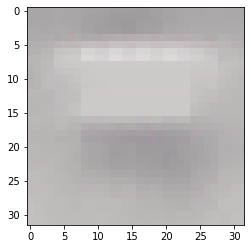

Epoch: 37 	Training Loss: 65.295366


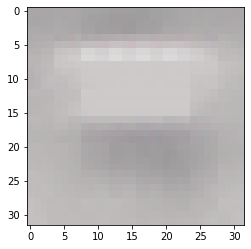

Epoch: 38 	Training Loss: 65.289682


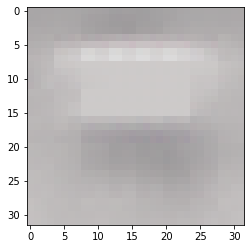

Epoch: 39 	Training Loss: 65.283872


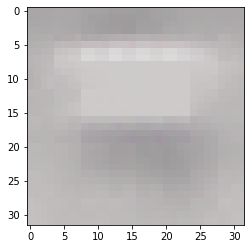

Epoch: 40 	Training Loss: 65.278760


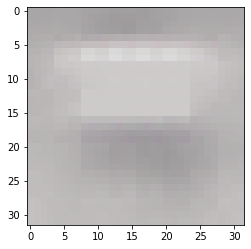

Epoch: 41 	Training Loss: 65.273050


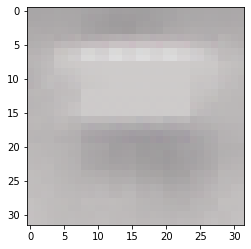

Epoch: 42 	Training Loss: 65.267857


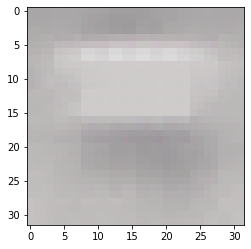

Epoch: 43 	Training Loss: 65.262499


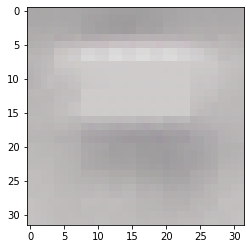

Epoch: 44 	Training Loss: 65.256821


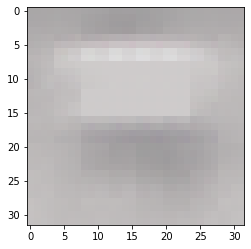

Epoch: 45 	Training Loss: 65.252061


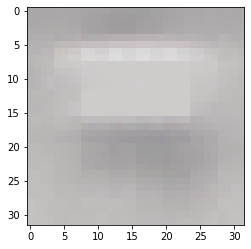

Epoch: 46 	Training Loss: 65.247600


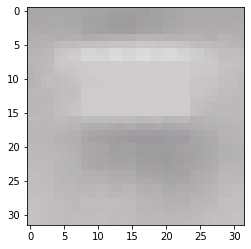

Epoch: 47 	Training Loss: 65.242511


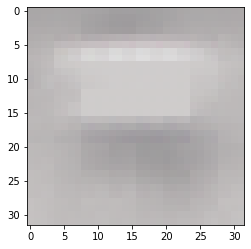

Epoch: 48 	Training Loss: 65.238233


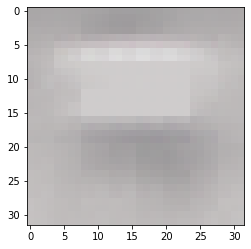

Epoch: 49 	Training Loss: 65.233902


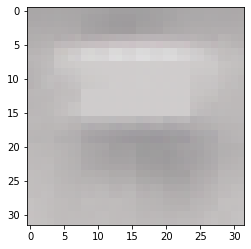

Epoch: 50 	Training Loss: 65.229756


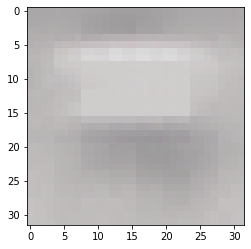

Epoch: 51 	Training Loss: 65.225958


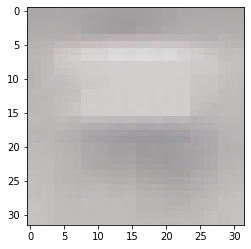

Epoch: 52 	Training Loss: 65.221356


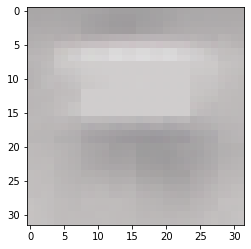

Epoch: 53 	Training Loss: 65.217090


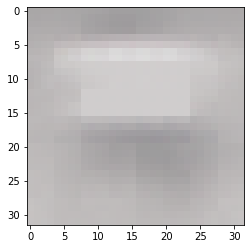

Epoch: 54 	Training Loss: 65.212630


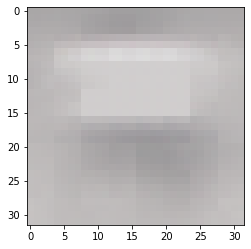

Epoch: 55 	Training Loss: 65.208504


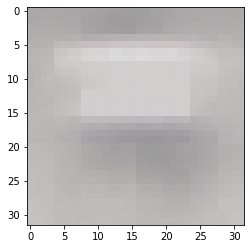

Epoch: 56 	Training Loss: 65.205142


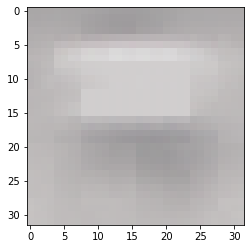

Epoch: 57 	Training Loss: 65.201774


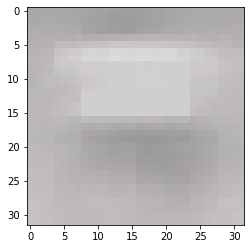

Epoch: 58 	Training Loss: 65.198154


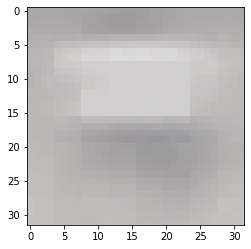

Epoch: 59 	Training Loss: 65.194691


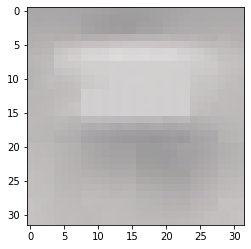

Epoch: 60 	Training Loss: 65.191598


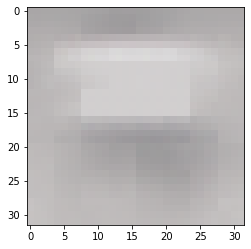

Epoch: 61 	Training Loss: 65.187972


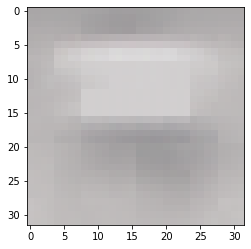

Epoch: 62 	Training Loss: 65.184959


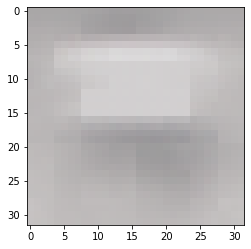

Epoch: 63 	Training Loss: 65.182002


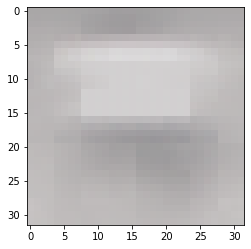

Epoch: 64 	Training Loss: 65.178991


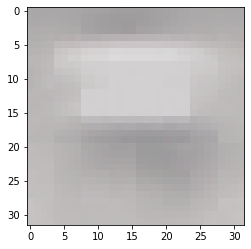

Epoch: 65 	Training Loss: 65.175908


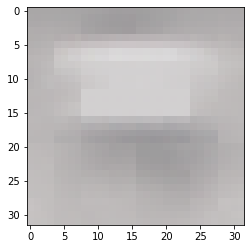

Epoch: 66 	Training Loss: 65.172939


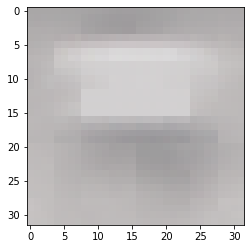

Epoch: 67 	Training Loss: 65.169789


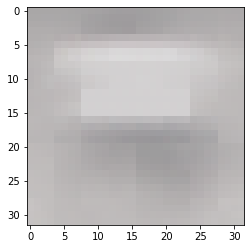

Epoch: 68 	Training Loss: 65.166748


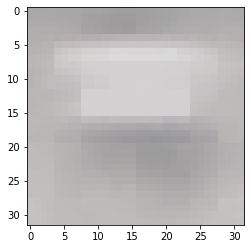

Epoch: 69 	Training Loss: 65.163463


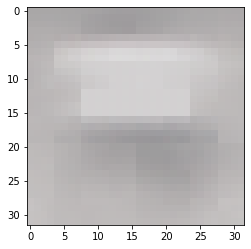

Epoch: 70 	Training Loss: 65.160982


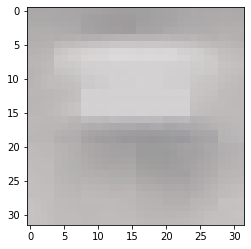

Epoch: 71 	Training Loss: 65.158203


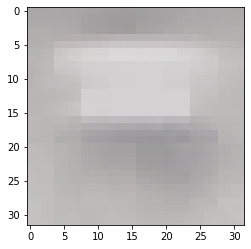

Epoch: 72 	Training Loss: 65.155403


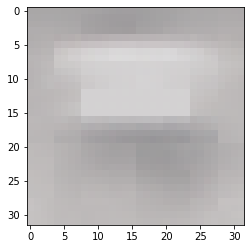

Epoch: 73 	Training Loss: 65.153051


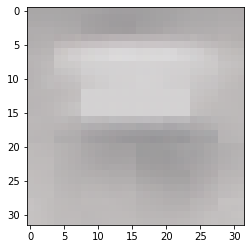

Epoch: 74 	Training Loss: 65.150621


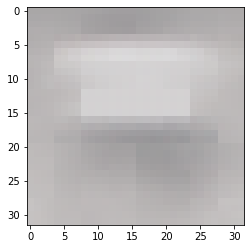

Epoch: 75 	Training Loss: 65.148463


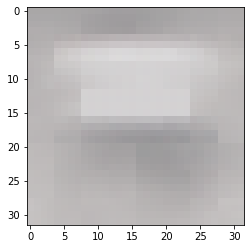

Epoch: 76 	Training Loss: 65.145366


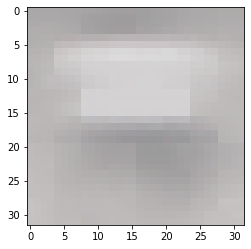

Epoch: 77 	Training Loss: 65.142799


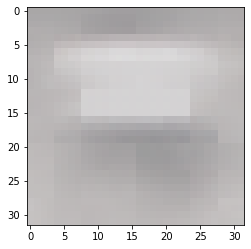

Epoch: 78 	Training Loss: 65.140533


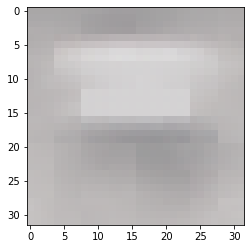

Epoch: 79 	Training Loss: 65.137572


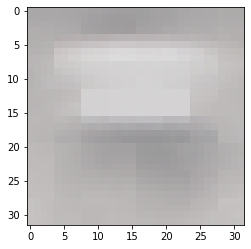

Epoch: 80 	Training Loss: 65.134707


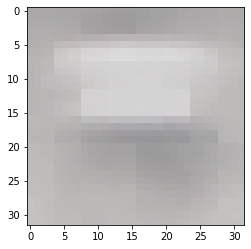

Epoch: 81 	Training Loss: 65.132222


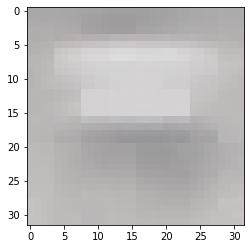

Epoch: 82 	Training Loss: 65.129833


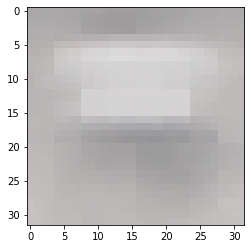

Epoch: 83 	Training Loss: 65.127240


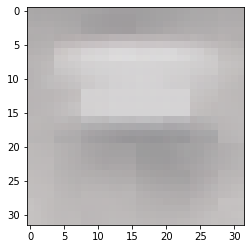

Epoch: 84 	Training Loss: 65.125038


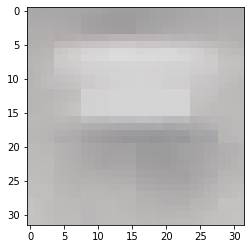

Epoch: 85 	Training Loss: 65.122982


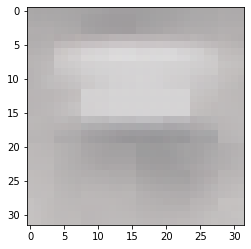

Epoch: 86 	Training Loss: 65.120753


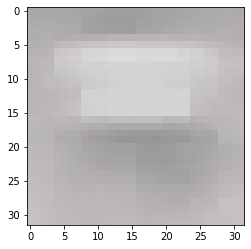

Epoch: 87 	Training Loss: 65.118861


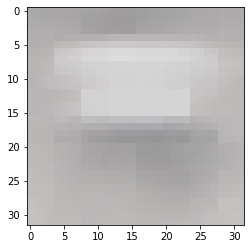

Epoch: 88 	Training Loss: 65.116583


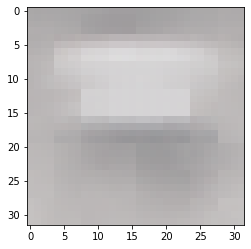

Epoch: 89 	Training Loss: 65.114165


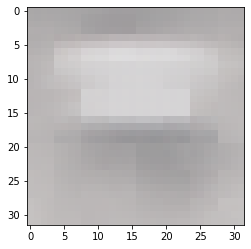

Epoch: 90 	Training Loss: 65.112017


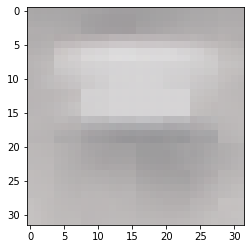

Epoch: 91 	Training Loss: 65.110225


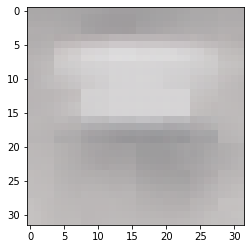

Epoch: 92 	Training Loss: 65.108921


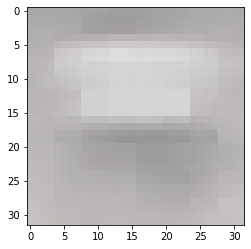

Epoch: 93 	Training Loss: 65.106655


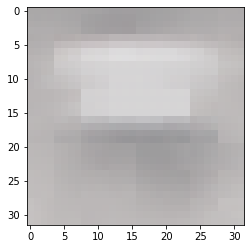

Epoch: 94 	Training Loss: 65.104733


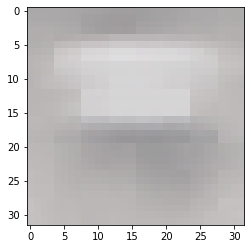

Epoch: 95 	Training Loss: 65.102439


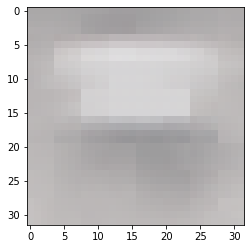

Epoch: 96 	Training Loss: 65.100381


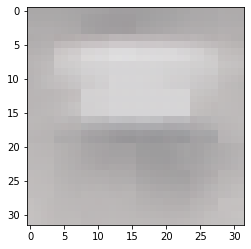

Epoch: 97 	Training Loss: 65.098087


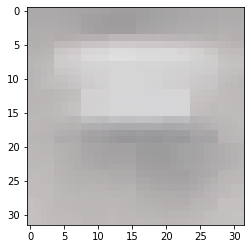

Epoch: 98 	Training Loss: 65.095545


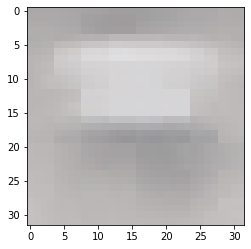

Epoch: 99 	Training Loss: 65.093882


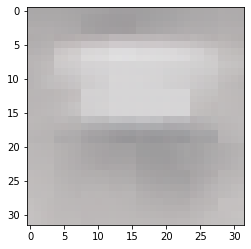

Epoch: 100 	Training Loss: 65.090939


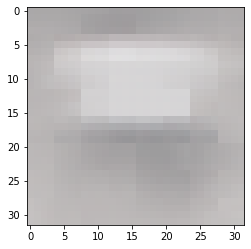

Epoch: 101 	Training Loss: 65.088974


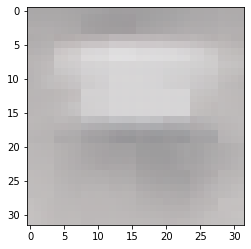

Epoch: 102 	Training Loss: 65.086918


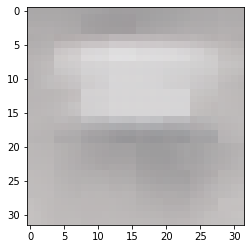

Epoch: 103 	Training Loss: 65.085037


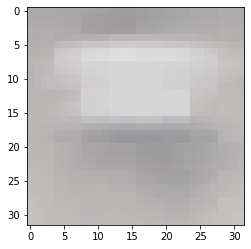

Epoch: 104 	Training Loss: 65.083250


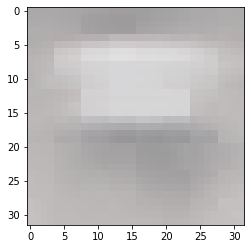

Epoch: 105 	Training Loss: 65.081503


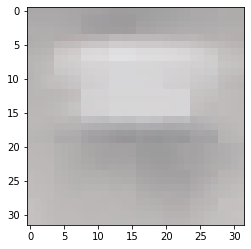

Epoch: 106 	Training Loss: 65.079538


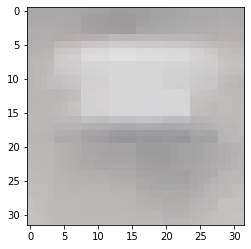

Epoch: 107 	Training Loss: 65.077588


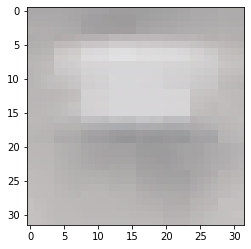

Epoch: 108 	Training Loss: 65.075740


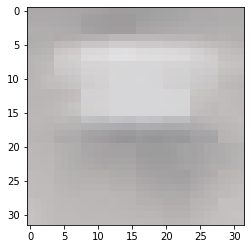

Epoch: 109 	Training Loss: 65.073997


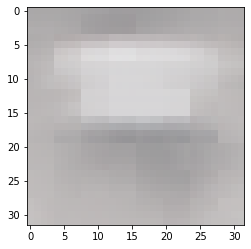

Epoch: 110 	Training Loss: 65.072101


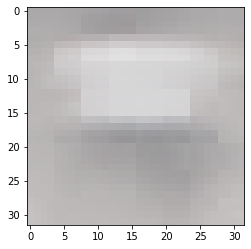

Epoch: 111 	Training Loss: 65.070278


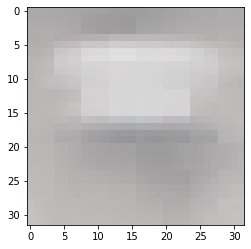

Epoch: 112 	Training Loss: 65.068454


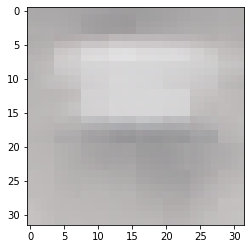

Epoch: 113 	Training Loss: 65.066902


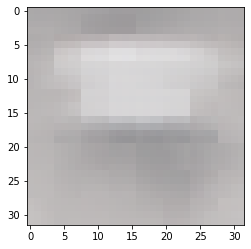

Epoch: 114 	Training Loss: 65.064904


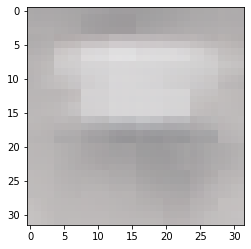

Epoch: 115 	Training Loss: 65.063128


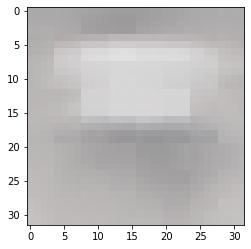

Epoch: 116 	Training Loss: 65.061586


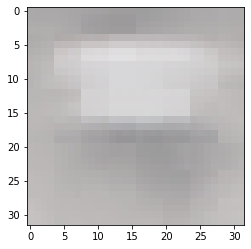

Epoch: 117 	Training Loss: 65.060106


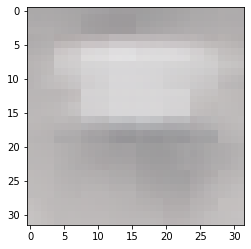

Epoch: 118 	Training Loss: 65.058539


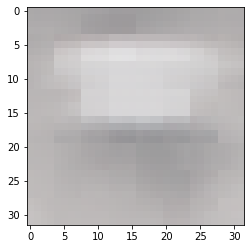

Epoch: 119 	Training Loss: 65.057096


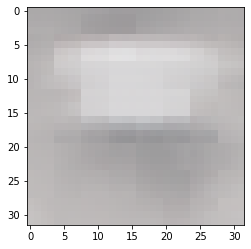

Epoch: 120 	Training Loss: 65.055415


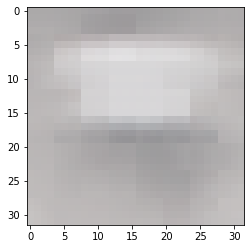

Epoch: 121 	Training Loss: 65.054253


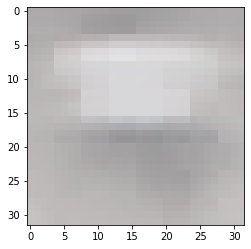

Epoch: 122 	Training Loss: 65.052198


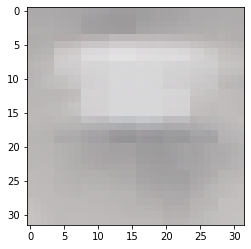

Epoch: 123 	Training Loss: 65.050501


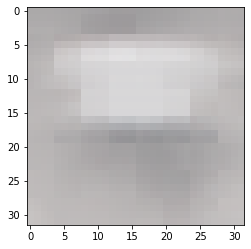

Epoch: 124 	Training Loss: 65.048354


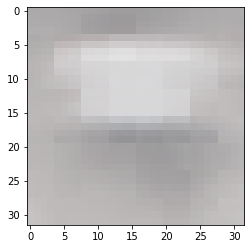

Epoch: 125 	Training Loss: 65.047004


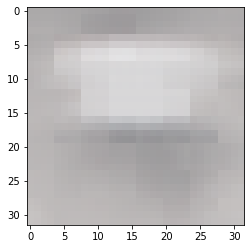

Epoch: 126 	Training Loss: 65.045333


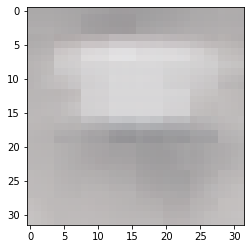

Epoch: 127 	Training Loss: 65.044138


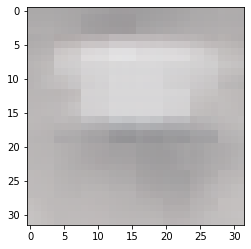

Epoch: 128 	Training Loss: 65.043215


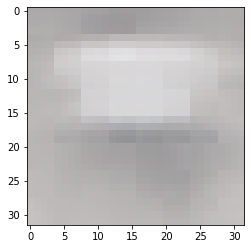

Epoch: 129 	Training Loss: 65.042149


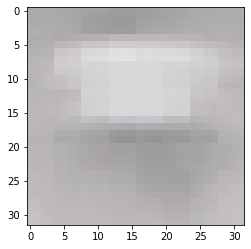

Epoch: 130 	Training Loss: 65.040303


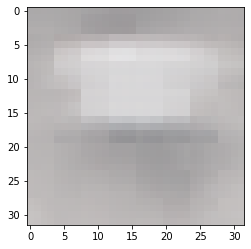

Epoch: 131 	Training Loss: 65.039035


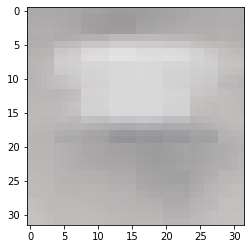

Epoch: 132 	Training Loss: 65.037978


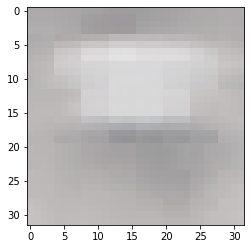

Epoch: 133 	Training Loss: 65.036965


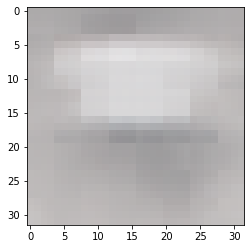

Epoch: 134 	Training Loss: 65.035507


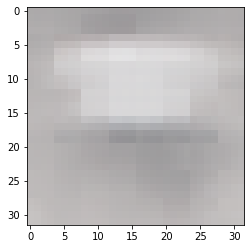

Epoch: 135 	Training Loss: 65.034426


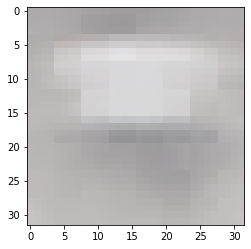

Epoch: 136 	Training Loss: 65.033216


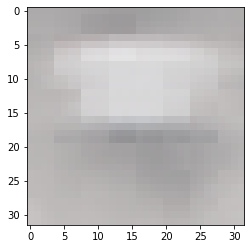

Epoch: 137 	Training Loss: 65.032545


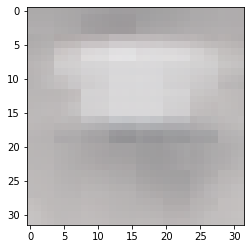

Epoch: 138 	Training Loss: 65.030661


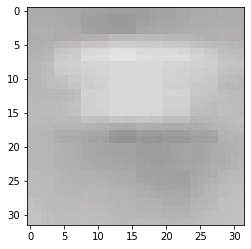

Epoch: 139 	Training Loss: 65.029803


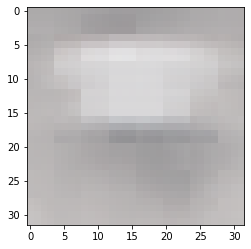

Epoch: 140 	Training Loss: 65.029159


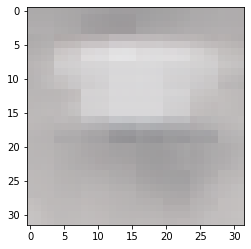

Epoch: 141 	Training Loss: 65.027844


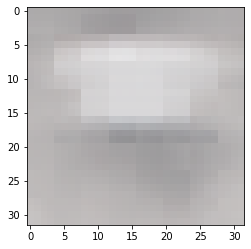

Epoch: 142 	Training Loss: 65.026323


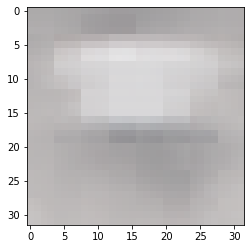

Epoch: 143 	Training Loss: 65.025067


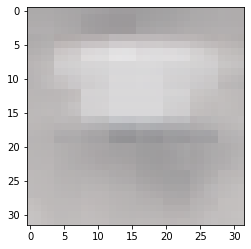

Epoch: 144 	Training Loss: 65.023945


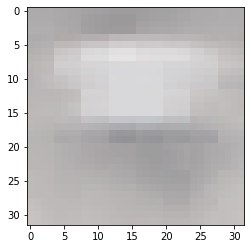

Epoch: 145 	Training Loss: 65.023010


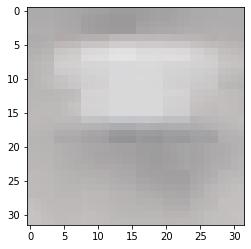

Epoch: 146 	Training Loss: 65.021524


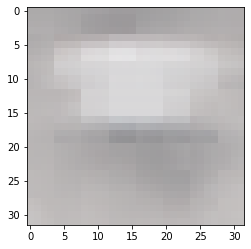

Epoch: 147 	Training Loss: 65.020794


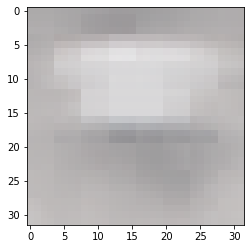

Epoch: 148 	Training Loss: 65.019722


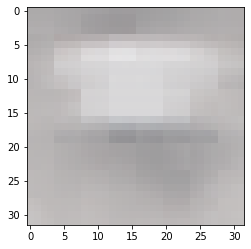

Epoch: 149 	Training Loss: 65.018987


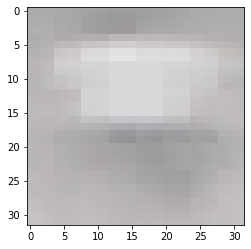

Epoch: 150 	Training Loss: 65.018703


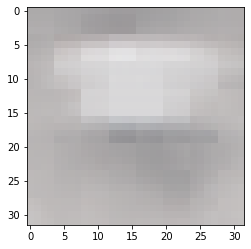

Epoch: 151 	Training Loss: 65.017801


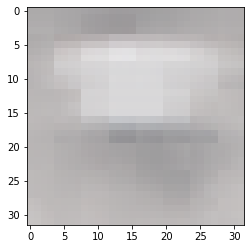

Epoch: 152 	Training Loss: 65.016456


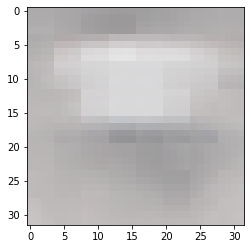

Epoch: 153 	Training Loss: 65.016194


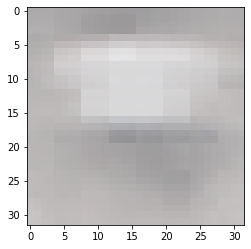

Epoch: 154 	Training Loss: 65.015423


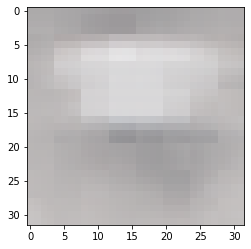

Epoch: 155 	Training Loss: 65.015154


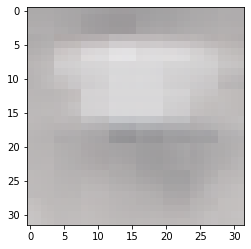

Epoch: 156 	Training Loss: 65.014134


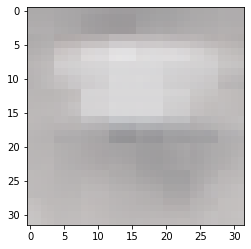

Epoch: 157 	Training Loss: 65.013587


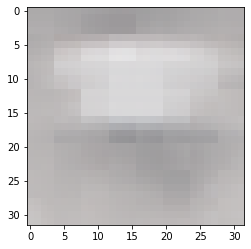

Epoch: 158 	Training Loss: 65.012376


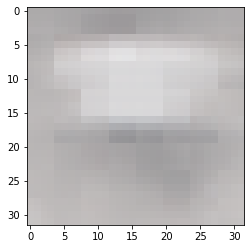

Epoch: 159 	Training Loss: 65.010985


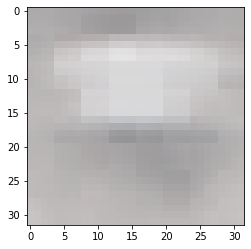

Epoch: 160 	Training Loss: 65.009589


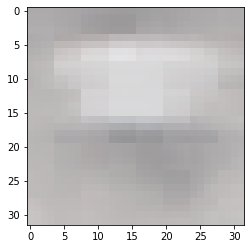

Epoch: 161 	Training Loss: 65.008039


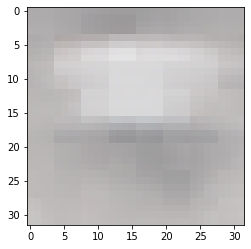

Epoch: 162 	Training Loss: 65.008320


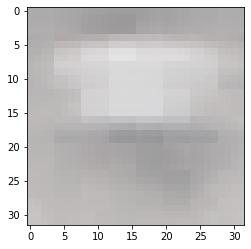

Epoch: 163 	Training Loss: 65.007331


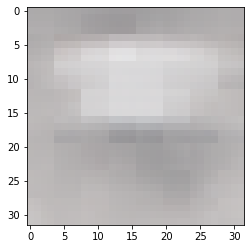

Epoch: 164 	Training Loss: 65.006384


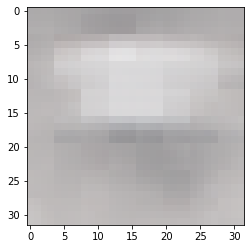

Epoch: 165 	Training Loss: 65.004696


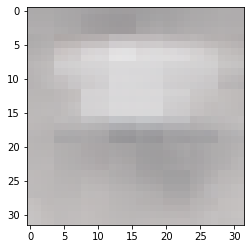

Epoch: 166 	Training Loss: 65.003365


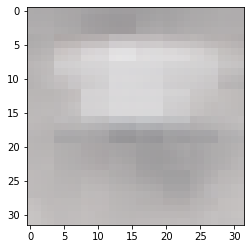

Epoch: 167 	Training Loss: 65.002358


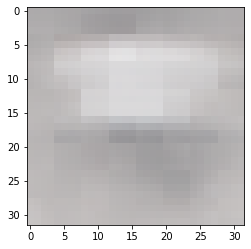

Epoch: 168 	Training Loss: 65.001294


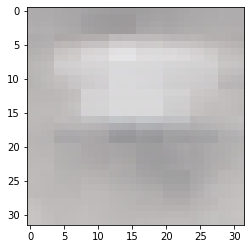

Epoch: 169 	Training Loss: 65.000563


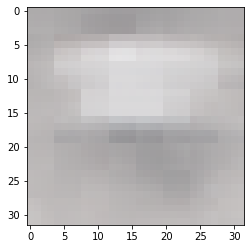

Epoch: 170 	Training Loss: 64.999902


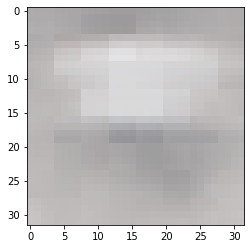

Epoch: 171 	Training Loss: 64.998594


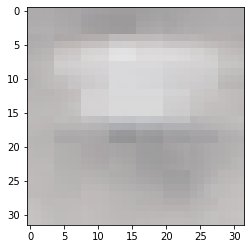

Epoch: 172 	Training Loss: 64.998296


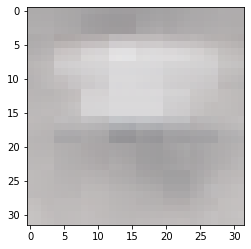

Epoch: 173 	Training Loss: 64.997057


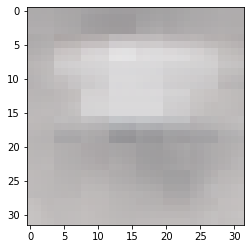

Epoch: 174 	Training Loss: 64.996334


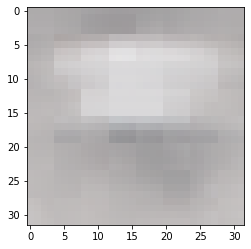

Epoch: 175 	Training Loss: 64.995419


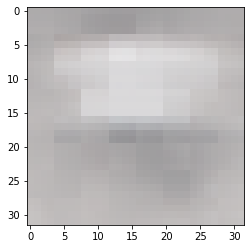

Epoch: 176 	Training Loss: 64.994250


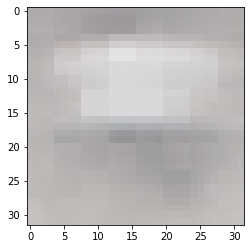

Epoch: 177 	Training Loss: 64.993294


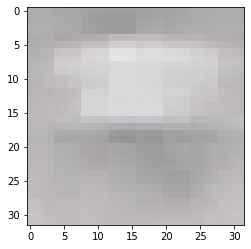

Epoch: 178 	Training Loss: 64.992717


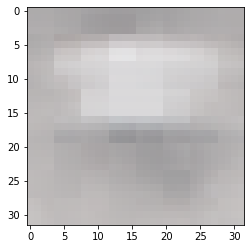

Epoch: 179 	Training Loss: 64.991816


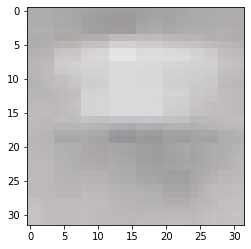

Epoch: 180 	Training Loss: 64.991637


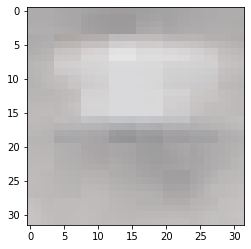

Epoch: 181 	Training Loss: 64.990949


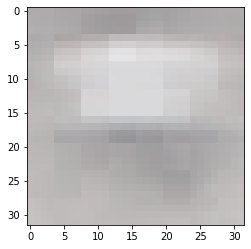

Epoch: 182 	Training Loss: 64.990663


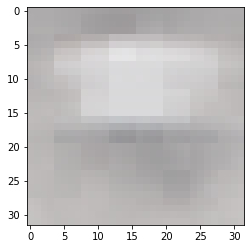

Epoch: 183 	Training Loss: 64.991006


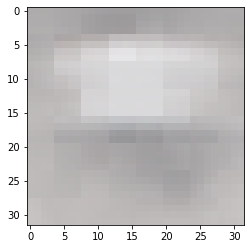

Epoch: 184 	Training Loss: 64.990831


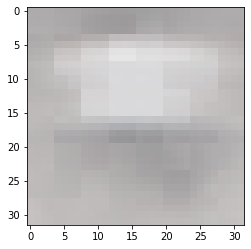

Epoch: 185 	Training Loss: 64.989667


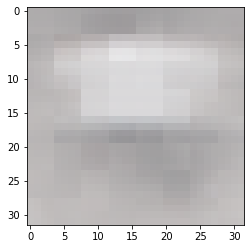

Epoch: 186 	Training Loss: 64.989542


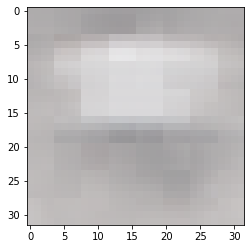

Epoch: 187 	Training Loss: 64.989684


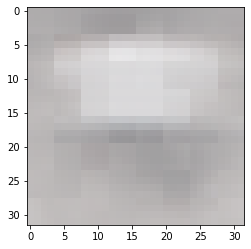

Epoch: 188 	Training Loss: 64.990081


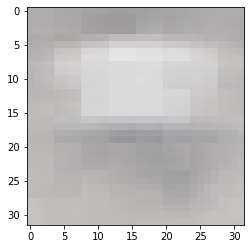

Epoch: 189 	Training Loss: 64.990019


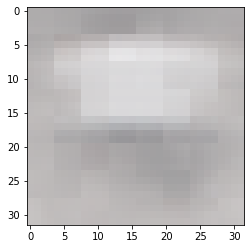

Epoch: 190 	Training Loss: 64.990519


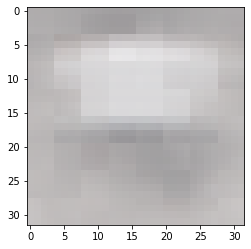

Epoch: 191 	Training Loss: 64.991142


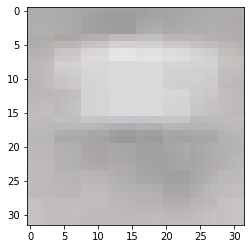

Epoch: 192 	Training Loss: 64.992547


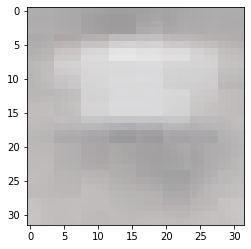

Epoch: 193 	Training Loss: 64.993583


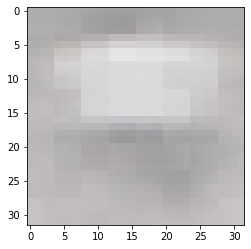

Epoch: 194 	Training Loss: 64.995983


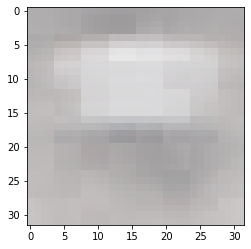

Epoch: 195 	Training Loss: 64.998690


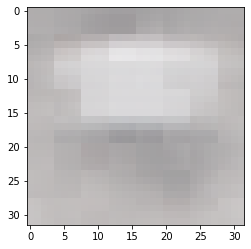

Epoch: 196 	Training Loss: 65.005278


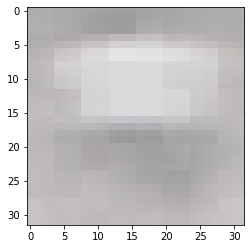

Epoch: 197 	Training Loss: 65.008759


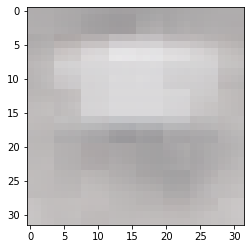

Epoch: 198 	Training Loss: 65.014241


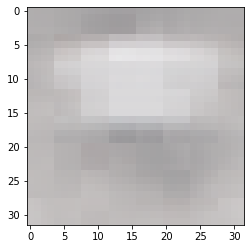

Epoch: 199 	Training Loss: 65.013642


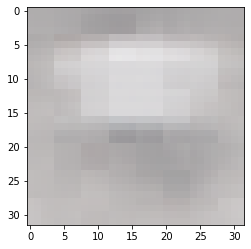

Epoch: 200 	Training Loss: 65.010474


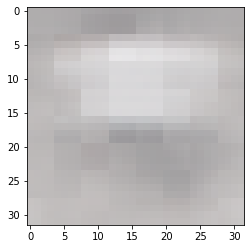

In [18]:
#Epochs
n_epochs = 200
loss_list = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data,data1 in zip(trainloader,trainloader1):
        images, user_id = data
        images1, user_id1 = data1
        images = images.to(device)
        images1 = images1.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(trainloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    loss_list.append(train_loss)
    imshow(outputs[0].detach().cpu())
    plt.show() 
    model.train()

In [44]:
torch.save(model.state_dict(), 'Proposed_AutoEncoder')

In [32]:
model.load_state_dict(torch.load('Proposed_AutoEncoder'))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Reshape()
    (7): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Reshape()
    (3): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (6): Sigmoid()
  )
)

torch.Size([100, 3, 32, 32])


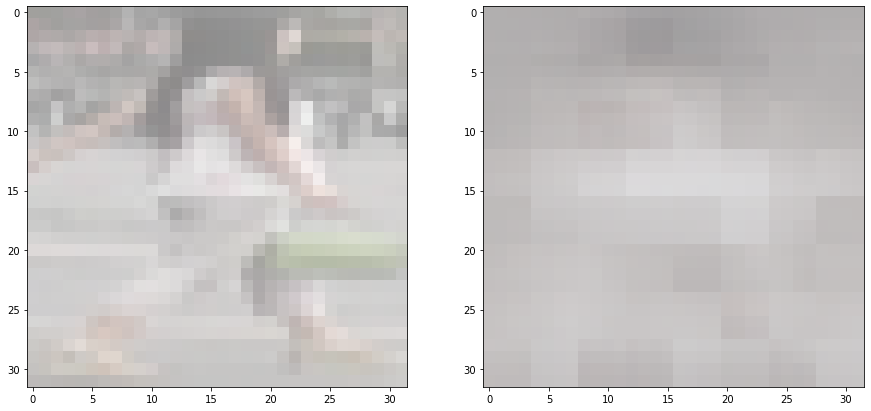

In [33]:
plt.figure(figsize=(15,10))
model.eval()

k = 5
for image, _ in trainloader :
    ax1 = plt.subplot(1, 2, 1)
    imshow(image.data[k])
    ax2 = plt.subplot(1, 2, 2)
    img = model(image.to(device))
    print(image.shape)
    imshow(img[k].detach().cpu().numpy())
    break
plt.show()

In [52]:
from scipy.spatial import distance

person_id_distance = {}

for _, person_id_batch in testloader :
    
    for person_id in person_id_batch :
        person_id_distance[person_id] = []

In [53]:
    

for image_batch, person_id_batch in testloader : 
    
    imgs_vector = model.encoder(image_batch.to(device))
    
    for img_vector, person_id in zip(imgs_vector, person_id_batch) :
        person_id_distance[person_id].append(img_vector.detach().cpu().numpy())
        

In [60]:
person_id_list = list(person_id_distance)

In [171]:
import random



ww = 0
www = 0
for i in range(500) :
    r1 = random.randrange(0,len(person_id_list))

    random.shuffle([person_id_list[r1]])
    t = distance.euclidean(person_id_distance[person_id_list[r1]][0], person_id_distance[person_id_list[r1]][1])
    o = []
    for i in range(1) :
        
        r2 = random.randrange(0,len(person_id_list))
        random.shuffle(person_id_distance[person_id_list[r2]])
        o.append(distance.euclidean(person_id_distance[person_id_list[r1]][0], person_id_distance[person_id_list[r2]][1]))

    
    if t< min(o) :
        ww = ww + 1
    else :
        www = www + 1
ww/(www + ww)

0.902

0.626

In [54]:
distance.euclidean(person_id_distance['857'][1],person_id_distance['857'][2])

4.058072090148926

In [139]:
person_id_distance

{'479': [array([ 0.17223449, -0.18720323,  0.38154268,  0.02466798, -0.02185701,
          0.08571605, -0.00190382,  0.14054216,  0.1867645 ,  0.5895281 ,
         -0.28922606,  0.11533068, -0.23593095, -0.04747975, -0.10404098,
         -0.02455123, -0.34213492, -0.15003785, -0.14176217,  0.3639069 ,
          0.11460016, -0.28580663,  0.09664847, -0.08780417, -0.01858757,
          0.16327247,  0.06888468,  0.23766729,  0.5628348 ,  0.8260187 ,
          0.32222864, -0.19378509,  0.20606923,  0.18219349,  0.19121271,
          0.18593012,  0.01893776,  1.0045918 , -0.1678336 ,  0.3116909 ,
         -0.04387616,  0.1071828 , -0.01248541,  0.00483887, -0.60545605,
          1.4776875 ,  0.41594648, -0.00591183,  0.0782904 ,  0.17164566,
          0.03164886,  0.17741597,  0.5423804 ,  0.00483182, -0.13928667,
          0.0207119 , -0.5865294 ,  0.12592417, -0.11534777,  0.08707754,
         -0.267762  , -0.8469881 , -0.8362889 ,  0.10862005, -0.07404619,
          1.0948173 , -0.018904